# Expansion Factor Exploratory Analysis
***
## Selecting Intersection Candidates

Our intersection segments of interest are

* Front/Bathurst to Front/Spadina
* King/Yonge to King/Jarvis
* King/University to King/Yonge

These were chosen as candidates because: 

* Data for these segments exist in the `bluetooth` and `miovision` schema 
* The distances are relatively short
* There are few places of interest down these segments
* There are few streets to turn on, so the volume from the starting point to the ending point is assumably relatively consistent  

In [65]:
# import relevant modules
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# connect to database
CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

 The SQL query below grab volume data from November 1st to November 8th. The query exccludes any missing data points in this time frame. Only Lights, Single-Unit Trucks, and Articulated Trucks were counted.   
 
 The `formatter` function simply substitutes intersection id's in to a multiline query string so 3 massive strings don't need to be assigned to variables. 

In [4]:
string = '''with missing_dates as (select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f
                EXCEPT
                select distinct(datetime_bin) from 
                (select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' 
                and classification_uid in (1,4,5))
                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin) f)

                select intersection_uid, datetime_bin, leg, dir, sum(volume) from miovision.volumes_15min
                where (intersection_uid = %d  and leg = 'E' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5)) or 

                (intersection_uid = %d  and leg = 'W' and dir = 'EB' 
                and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and datetime_bin not in (select * from missing_dates)
                and classification_uid in (1,4,5))

                group by intersection_uid, datetime_bin, leg, dir
                order by intersection_uid, datetime_bin; '''


def formatter(string, int1, int2):
    return string % (int2, int1, int1, int2)

#formatter(string, 5, 6)

#frontnew = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)

front = pandasql.read_sql(pg.SQL(formatter(string,5,6)), con)
king1 = pandasql.read_sql(pg.SQL(formatter(string,18,20)), con)
king2 = pandasql.read_sql(pg.SQL(formatter(string,15,18)), con)



Separate each intersection into individual dataframes. 

In [5]:
front5 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 5)
front6 = pd.DataFrame(front.loc[i,] for i in range(len(front)) if front.loc[i,]['intersection_uid'] == 6)
king15 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 15)
king182 = pd.DataFrame(king2.loc[i,] for i in range(len(king2)) if king2.loc[i,]['intersection_uid'] == 18)
king181 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 18)
king20 = pd.DataFrame(king1.loc[i,] for i in range(len(king1)) if king1.loc[i,]['intersection_uid'] == 20)

Below are plots of the beginning of the segments (red) compared against the end of the segments (blue). If the through volume is consistent, red and blue lines should greatly overlap. 

It can be seen that for each graph, there is great overlap with some noise for each intersection. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


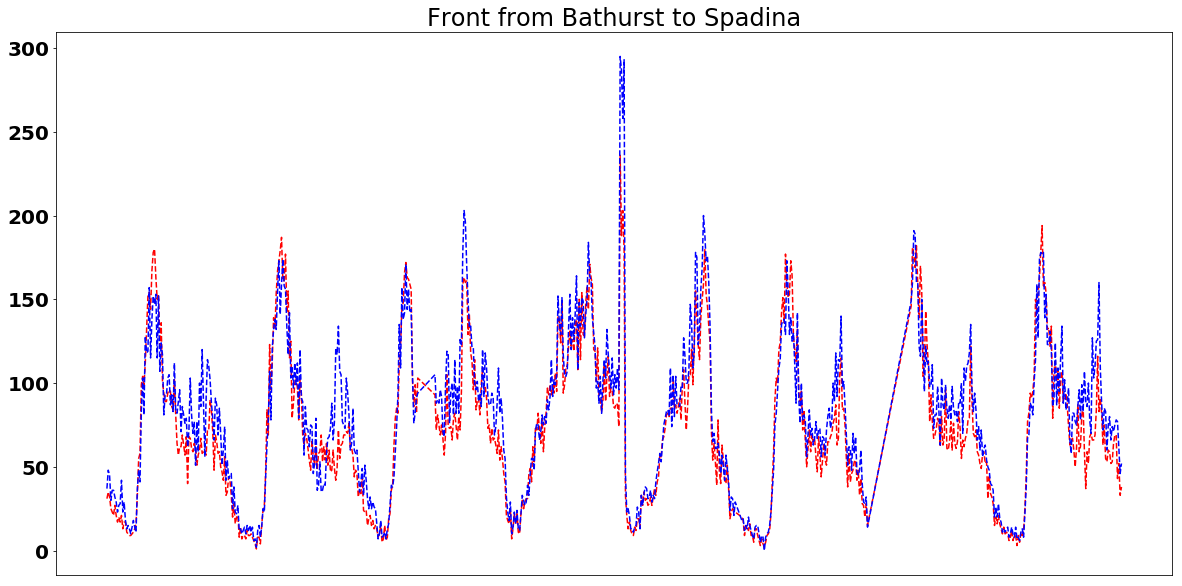

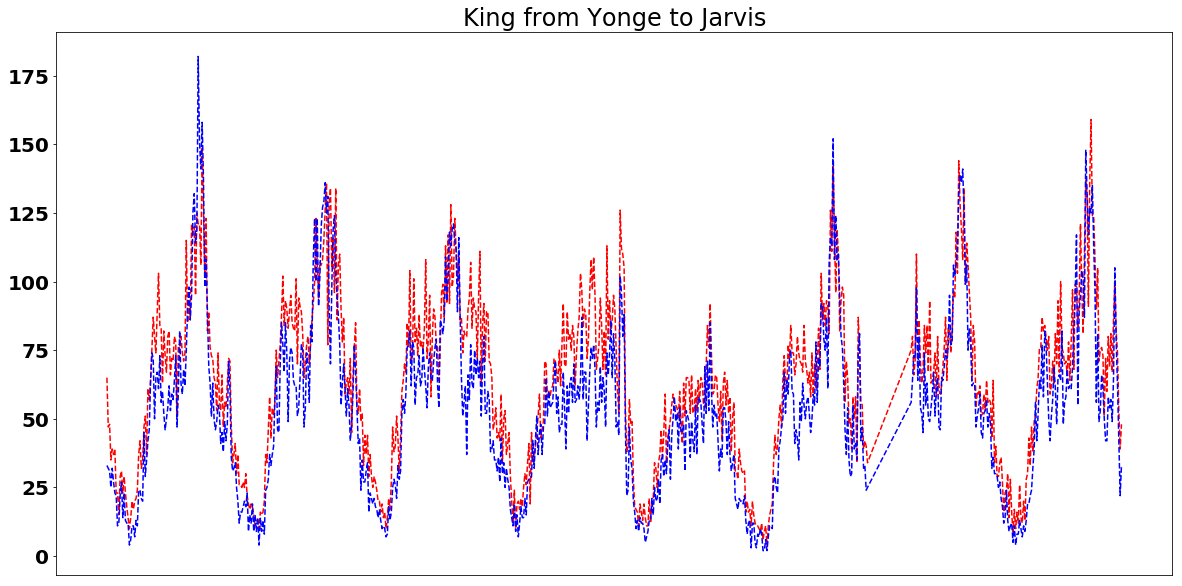

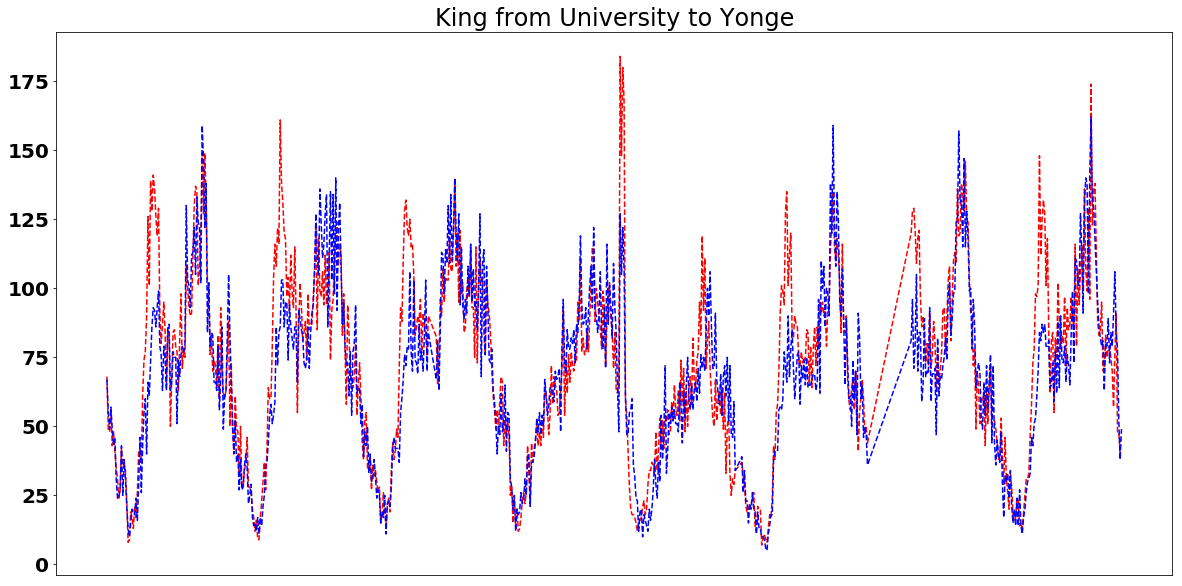

In [27]:
plt.figure(figsize = (20,10))
plt.plot(front5['datetime_bin'], front5['sum'], 'r--', front6['datetime_bin'], front6['sum'], 'b--')
plt.title('Front from Bathurst to Spadina')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (20,10))
plt.plot(king181['datetime_bin'], king181['sum'], 'r--', king20['datetime_bin'], king20['sum'], 'b--')
plt.title('King from Yonge to Jarvis')
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.figure(figsize = (20,10))
plt.plot(king15['datetime_bin'], king15['sum'], 'r--', king182['datetime_bin'], king182['sum'], 'b--')
plt.title('King from University to Yonge')
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])


plt.show()

For each segment, the beginning and ending volumes are subtracted, squared, and summated, to give a sort of residual metric we can compare the segments against. It can be seen that King from Yonge to Jarvis has the lowest value, indicating the best volume consistency. However, take note that this data came just before the King Street pilot, and we wish to minimize noise as much as possible. 

In [7]:
((front6.reset_index(drop = True)['sum'].subtract(front5.reset_index(drop = True)['sum']))**2).sum(),((king20.reset_index(drop = True)['sum'].subtract(king181.reset_index(drop = True)['sum']))**2).sum(), ((king182.reset_index(drop = True)['sum'].subtract(king15.reset_index(drop = True)['sum']))**2).sum()

(244345.0, 191591.0, 241779.25)

Below are scatter plots for each segment, where the beginning point volumes are compared to ending point volumes. If the volumes are very consistent, the scatter plot should follow closely along the line $y = x$. It can be seen that the first and second plot do this quite well. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


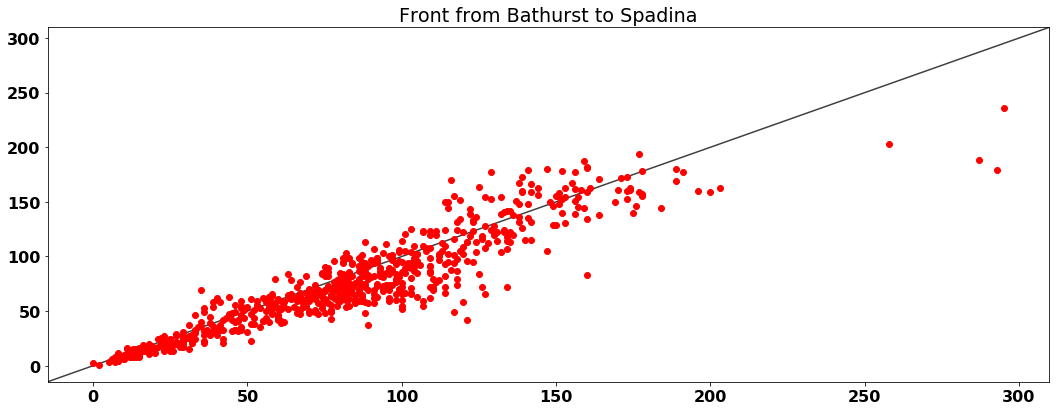

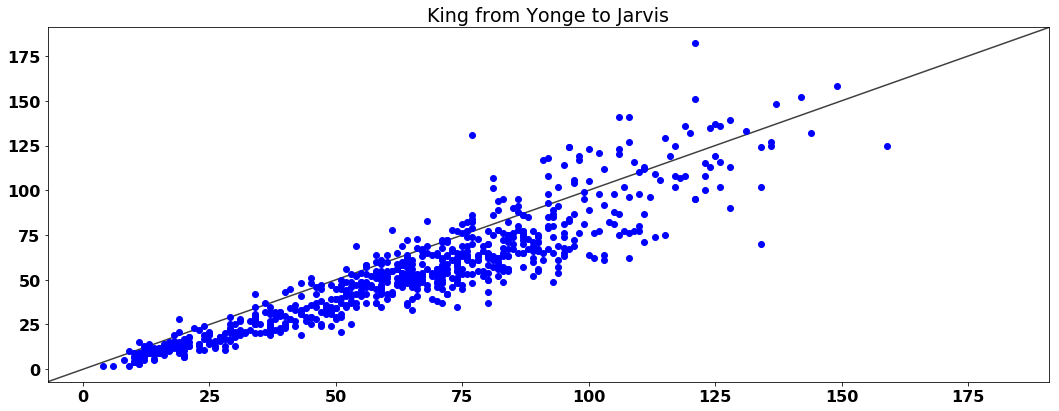

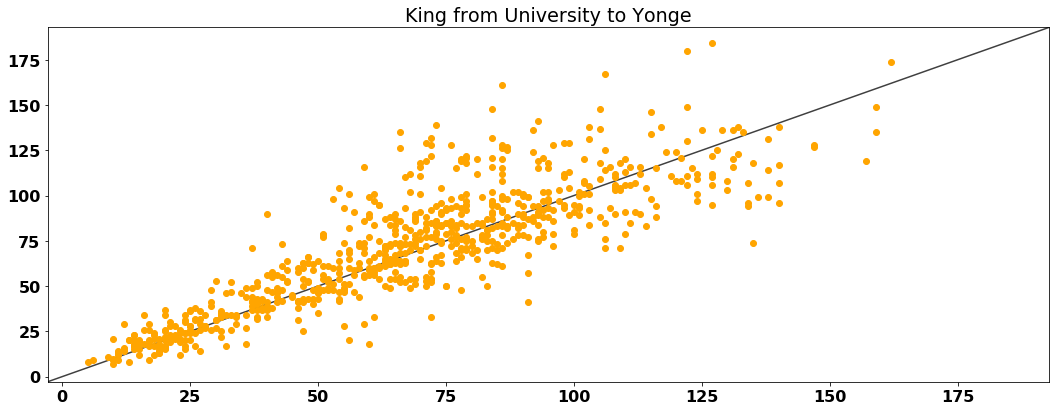

In [29]:
font = {'family' : 'normal',
        'size'   : 16}


fig, ax = plt.subplots()
ax.scatter(front6.reset_index(drop = True)['sum'], front5.reset_index(drop = True)['sum'], c = 'red')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

plt.title('Front from Bathurst to Spadina')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.tight_layout()

fig, ax = plt.subplots()
ax.scatter(king181.reset_index(drop = True)['sum'], king20.reset_index(drop = True)['sum'], c = 'blue')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

# now plot both limits against eachother
plt.title('King from Yonge to Jarvis')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.tight_layout()


fig, ax = plt.subplots()
ax.scatter(king182.reset_index(drop = True)['sum'], king15.reset_index(drop = True)['sum'], c = 'orange')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

plt.title('King from University to Yonge')
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.set_figheight(6)
fig.set_figwidth(15)
plt.rc('font', **font)
plt.tight_layout()

plt.show()


From the above, Front seems like the best plot. For the other two, notice how as the volume increases, so does the variance/noise. 



For this reason, we choose Front St. from Bathurst to Spadina. It seems like the volume data is quite consistent. Moreover, we arbitrarily choose Front/Spadina as our intersection of interest for volume measurement. 











## Analyzing Front/Spadina 
***

We create a string that will be a general query for grabbing bluetooth and volume data. We create a function `formatter2` that takes in a string and intersection input and formats the intersection into the SQL string. 

We then create a dataframe called `frontbt` containing volume and bluetooth data. 

In [73]:
string = '''select bt.datetime_bin, bt.obs, mio.volume from (
            select intersection_uid, datetime_bin, leg, dir, sum(volume) as volume from miovision.volumes_15min
            where (intersection_uid = %d  and leg = 'W' and dir = 'EB' 
            and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08' and classification_uid in (1,4,5))

            group by intersection_uid, datetime_bin, leg, dir
            order by intersection_uid, datetime_bin) mio, 

            (select datetime_bin, obs from bluetooth.aggr_15min
            where analysis_id = 1454523
            and datetime_bin::date >= '2017-11-01' and datetime_bin::date <= '2017-11-08') bt

            where mio.datetime_bin = bt.datetime_bin;'''


def formatter2(intersection):
    return string % (intersection)


frontbt = pandasql.read_sql(pg.SQL(formatter2(6)), con)
frontbt


,datetime_bin,obs,volume
0,2017-11-01 00:15:00,2,48.0
1,2017-11-01 00:30:00,2,45.0
2,2017-11-01 01:00:00,1,36.0
3,2017-11-01 01:15:00,3,36.0
4,2017-11-01 01:30:00,2,32.0
5,2017-11-01 01:45:00,1,29.0
6,2017-11-01 02:15:00,1,27.0
7,2017-11-01 02:30:00,1,28.0
8,2017-11-01 02:45:00,2,42.0
9,2017-11-01 03:00:00,1,23.0


Let's plot the bluetooth and volume data and look for any patterns.


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


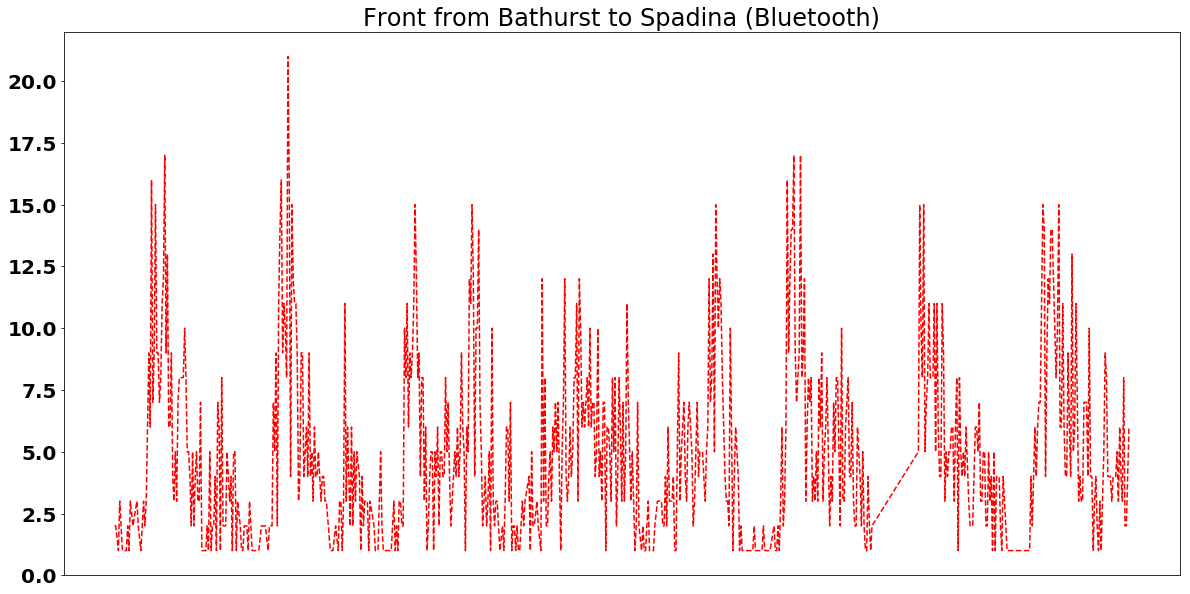

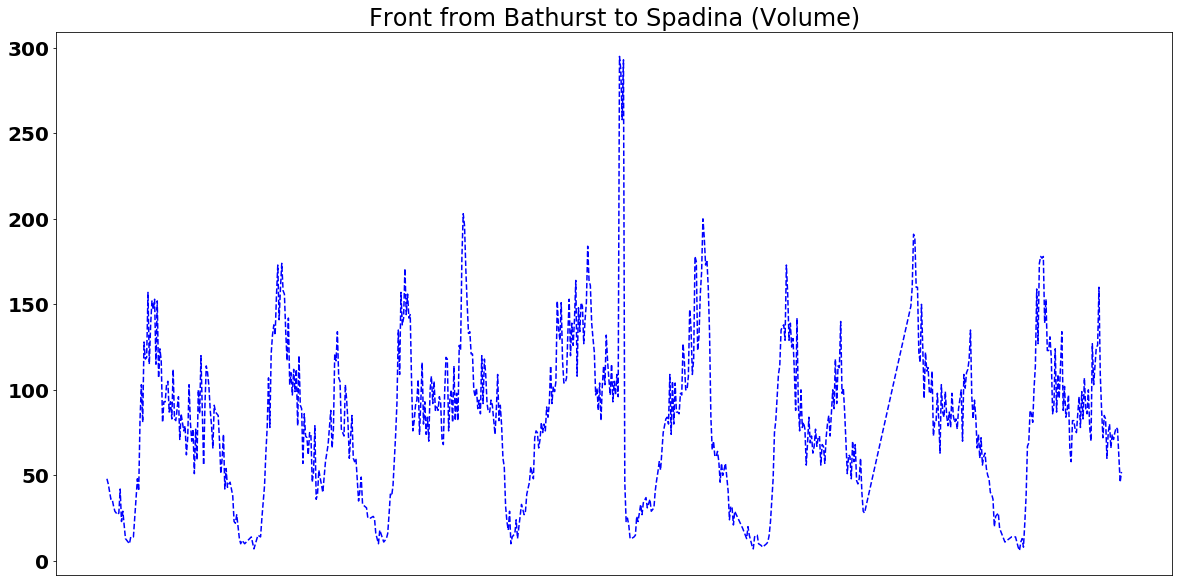

In [74]:
plt.figure(figsize = (20,10))
plt.plot(frontbt['datetime_bin'], frontbt['obs'],'r--')
plt.title('Front from Bathurst to Spadina (Bluetooth)')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])

plt.figure(figsize = (20,10))
plt.plot(frontbt['datetime_bin'], frontbt['volume'], 'b--')
plt.title('Front from Bathurst to Spadina (Volume)')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])



plt.show()

As seen below, the data is relatively similar on different scales. Notice how volume peaks and valleys occur during bluetooth peaks and valleys. 

We perform a regression on the data. We ignore the intercept value, as we hypothesize the volume data is a scaled version of the bluetooth data, i.e. an expansion factor is at play. The formula is as follows:

$Volume = a*Obs$

Where a is a scaling factor. 

In [79]:
fit = ols("volume ~ obs + 0", data=frontbt).fit()

The summary below indicates that the factor is extremely significant. Moreover, an R-squared value of 0.8 tells us that 80% of the variation in Volume can be explained by the model. 

In [80]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      v   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     2639.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):          3.74e-233
Time:                        16:09:10   Log-Likelihood:                -3436.2
No. Observations:                 663   AIC:                             6874.
Df Residuals:                     662   BIC:                             6879.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
obs           13.8838      0.270     51.371      0.000      13.353      14.414
==============================================================================
Omnibus:                       60.917   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.143
Skew:                           0.353   Prob(JB):                     5.78e-49
Kurtosis:                       5.746   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We summarize our findings graphically with the plots below. 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


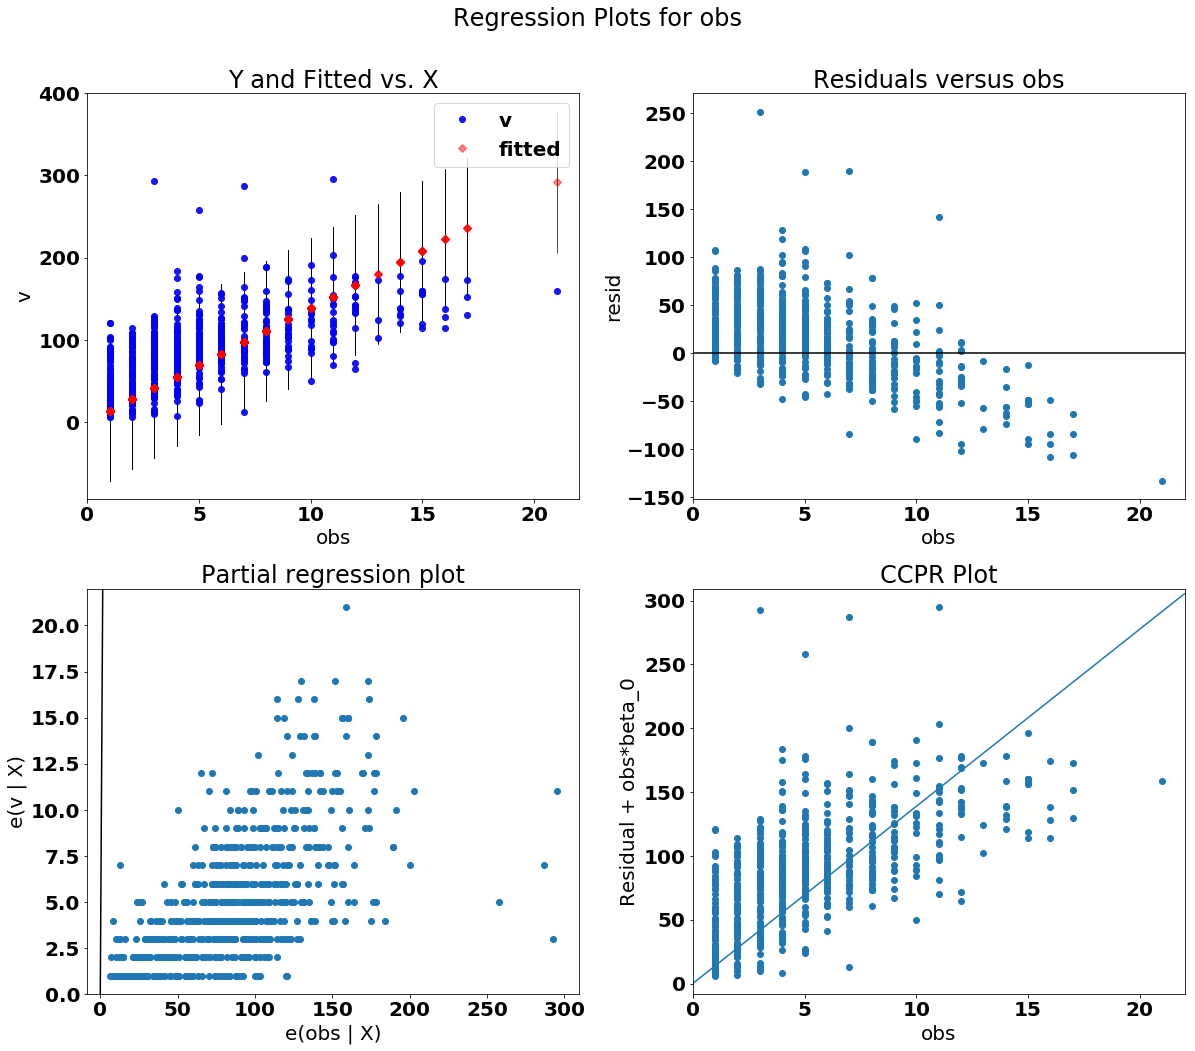

In [97]:
fig = plt.figure(figsize=(17,15))
fig = sm.graphics.plot_regress_exog(result, "obs", fig=fig)

#plt.tight_layout()
plt.show()


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


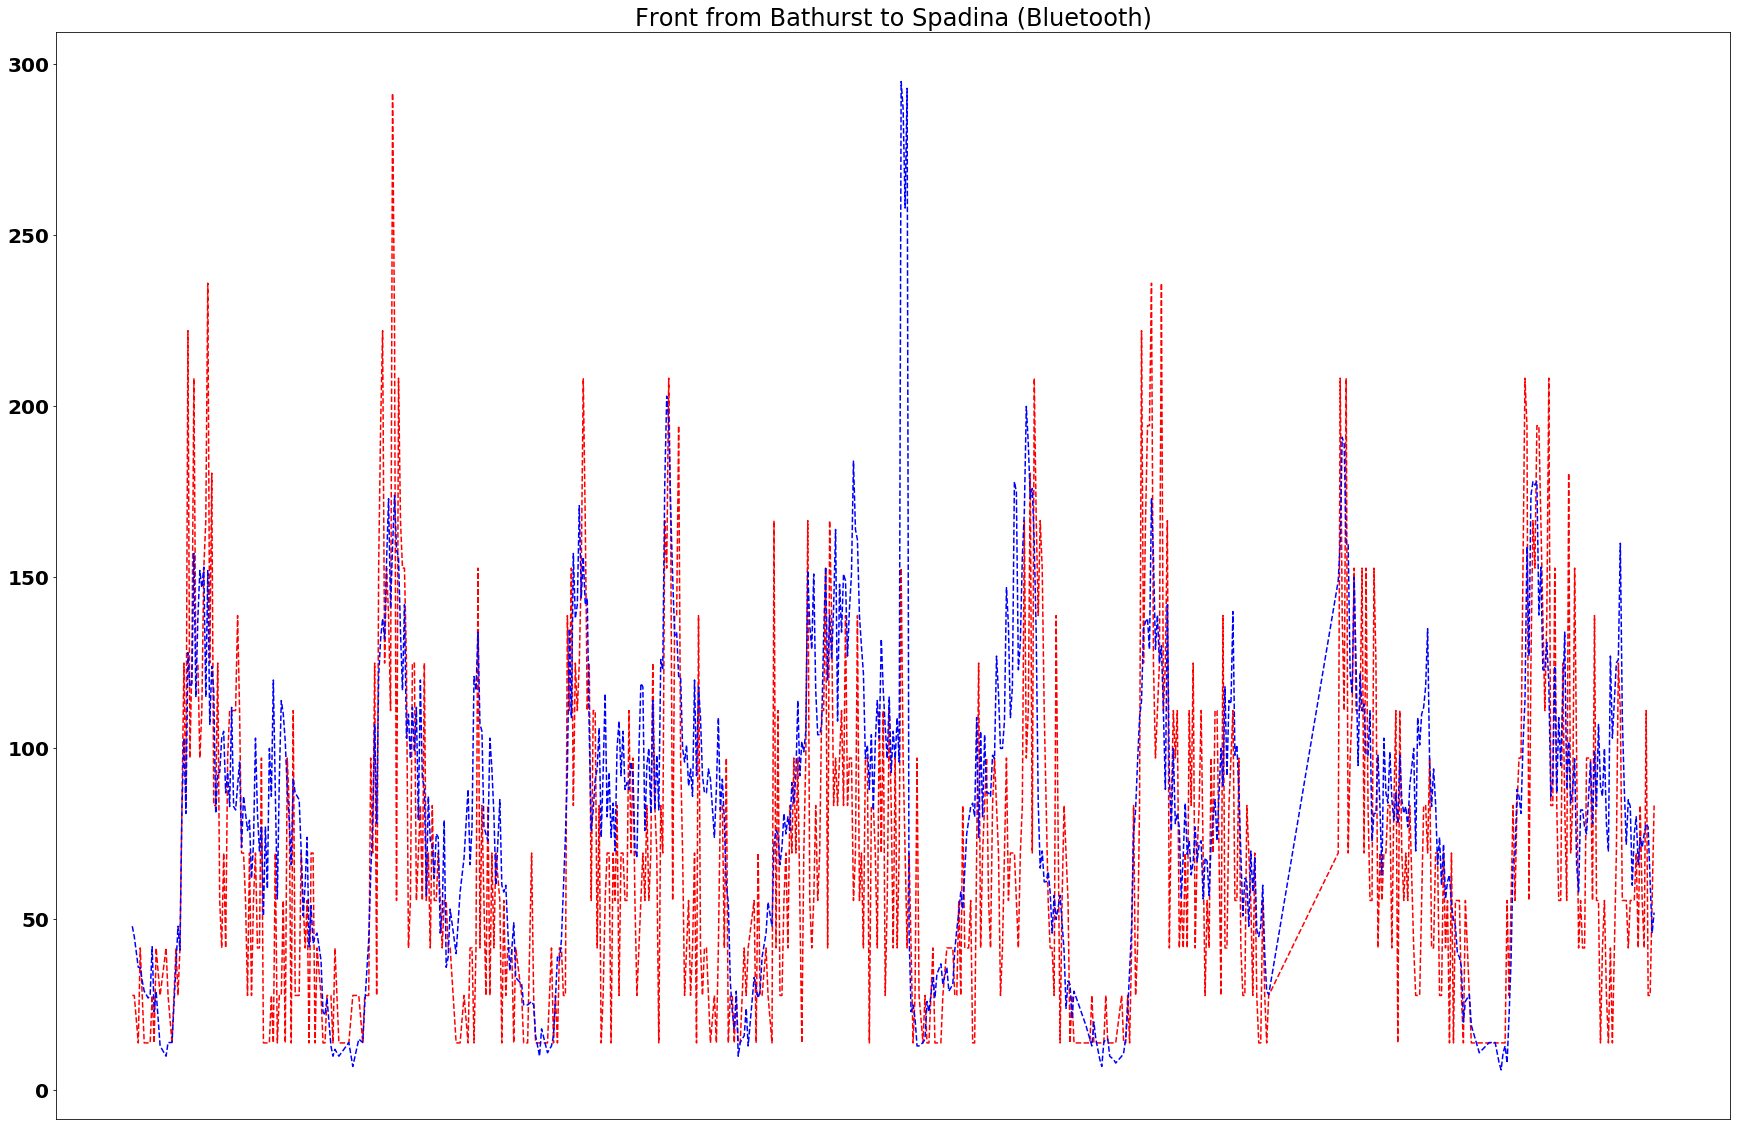

In [56]:
plt.figure(figsize = (30,20))
plt.plot(frontbt['datetime_bin'], frontbt['obs']*13.8838,'r--', frontbt['datetime_bin'], frontbt['v'], 'b--')
plt.title('Front from Bathurst to Spadina (Bluetooth)')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.axes().get_xaxis().set_ticks([])
plt.show()